(100, 40)
(40, 100)
(40, 100, 1, 4)


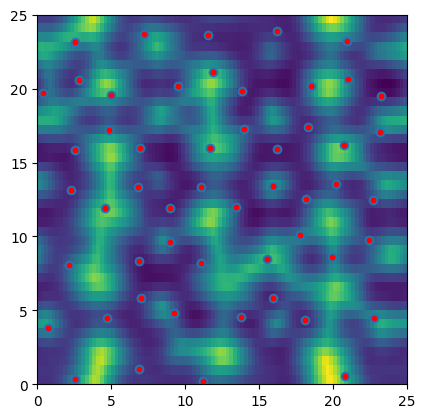

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ase import io

from src.utils import vec2box, box2vec

path = "/mnt/e/simu_data/bulk-Hup-Data/20240923-bulk-Hup-test/afm/icehupT160_2000000_0_12_0/0.png"
struct = "/mnt/e/simu_data/bulk-Hup-Data/20240923-bulk-Hup-test/label/icehupT160_2000000_0_12_0.poscar"
from PIL import Image

img = np.array(Image.open(path).convert('L').resize((40, 100))) # W, H
img = np.rot90(img, k=-1)
# img = img.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)

AT = io.read(struct)

cell = AT.cell.array

X = AT.cell.array[0,0]
Y = AT.cell.array[1,1]

AT = AT[AT.numbers == 8].positions

box = vec2box(AT @ np.linalg.inv(cell), box_size=(40, 100, 1))
print(box.shape)
conf, rs, *_ = box2vec(box[...,0], box[..., 1:4])
rs = rs @ cell
plt.scatter(rs[...,0], rs[...,1])
plt.scatter(AT[:, 0], AT[:, 1], c='r', s=10)
plt.imshow(box[:,:,0,0] + img, extent=[0, X, 0, Y]) # Y, X


torch.Size([1, 10, 80, 100])
tensor([[0.2089, 0.1906, 0.1851,  ..., 0.1823, 0.1952, 0.1873],
        [0.1980, 0.2014, 0.1812,  ..., 0.1840, 0.1822, 0.1774],
        [0.2062, 0.1939, 0.1970,  ..., 0.1709, 0.1947, 0.1860],
        ...,
        [0.1923, 0.2149, 0.2388,  ..., 0.2049, 0.1694, 0.1750],
        [0.1957, 0.2153, 0.2093,  ..., 0.1908, 0.2103, 0.1969],
        [0.1893, 0.1857, 0.1864,  ..., 0.1830, 0.1917, 0.1950]])
torch.Size([24, 32, 4, 8])


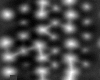

In [5]:
from configs.detect import DetectConfig
from src.dataset import DetectDataset
cfg = DetectConfig()

train_dts = DetectDataset(cfg.dataset.train_path,
                                       mode='afm+label',
                                       num_images=cfg.dataset.num_images,
                                       image_size=(100, 80),
                                       image_split=cfg.dataset.image_split,
                                       real_size=cfg.dataset.real_size,
                                       box_size=(24, 32, 4),
                                       random_transform=True,
                                       random_noisy=0.1,
                                       random_cutout=True,
                                       random_jitter=True,
                                       random_blur=True,
                                       random_shift=True,
                                       random_flipx=False,
                                       random_flipy=False)

name, afm, grid, atoms = train_dts[0]
import numpy as np
from PIL import Image
print(afm.shape)
print(afm[0,0])
print(grid.shape)
img = Image.fromarray((afm[0,0].numpy() * 255).astype(np.int8))
img.show()

In [ ]:
path = "/mnt/e/simu_data/sq37/combine_afm/sq37-1l-100-117"
model_path = "/mnt/e/simu_data/det_0530_EP10.pkl"

import torch
import numpy as np
from configs.detect import DetectConfig
from src.dataset import DetectDataset
from src.network import UNetND
from src.utils import box2atom
from ase import io
from matplotlib import pyplot as plt
from utils import water_solver
cfg = DetectConfig()

model_dic = cfg.model.params.__dict__
# model_dic['in_size'] = (10, 100, 80)
# model_dic['out_size'] = (4, 32, 24)
net = UNetND(**cfg.model.params.__dict__).to('cuda')

params = torch.load(model_path)
net.load_state_dict(params)

net.eval().requires_grad_(False)

train_dts = DetectDataset(path,
                        mode='afm+crop',
                        num_images=10,
                        image_size=(100,100),
                        image_split=None,
                        real_size=cfg.dataset.real_size,
                        box_size=(32, 32, 4),
                        random_transform=False,
                        random_noisy=0.1,
                        random_cutout=True,
                        random_jitter=True,
                        random_blur=True,
                        random_shift=True,
                        random_flipx=False,
                        random_flipy=False,
                        normalize=False)

pre_atoms = []

fig = plt.figure()

ax1, ax2 = fig.subplots(1, 2)

for i in range(len(train_dts)):
    name, afm, _, _ = train_dts[i]
    
    with torch.no_grad():
        pred = net(afm[None].cuda()).cpu().numpy()
    
    atoms = box2atom(pred[0],
                    cfg.dataset.real_size,
                    0.5,
                    cutoff=(1.036, 0.7392),
                    nms=cfg.dataset.nms)

    pre_atoms.append(atoms)
pre_atoms_combine = train_dts.combine_label_crop(pre_atoms)

atoms = water_solver(pre_atoms_combine)
io.write("sq37-1l-100-117.xyz", atoms)

ModuleNotFoundError: No module named 'utils'